# Initialization Cells: Run this first!

In [3]:
using Pkg
Pkg.activate(".")
Pkg.add("JLD")
Pkg.add("Flux")
Pkg.add("IterTools")

using Plots, Interact, JLD, Flux
using Flux: onehotbatch, argmax, crossentropy, throttle, mse, onecold, shuffle
using Flux.Data: DataLoader
using IterTools: ncycle, partition

theme(
    :wong;
    markerstrokewidth=0.5,
    markerstrokecolor=:white,
    alpha=0.7,
    label=""
);

 Activating environment at `~/dev/Continuum-ML-F20/Project.toml`


   Updating registry at `~/.julia/registries/General`


┌ Warning: could not download https://pkg.julialang.org/registries
└ @ Pkg.Types /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/Pkg/src/Types.jl:951
  Resolving package versions...
No Changes

to `~/dev/Continuum-ML-F20/Project.toml`
No Changes to `~/dev/Continuum-ML-F20/Manifest.toml`
  Resolving

package versions...
No Changes

to `~/dev/Continuum-ML-F20/Project.toml`
No Changes to `~/dev/Continuum-ML-F20/Manifest.toml`
  Resolving package versions...
No Changes

HTML{String}(&quot;&lt;script&gt;\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\&quot;webio-warning-18273099504326622947\&quot;);\n    var hide = function () {\n        var script = document.getElementById(\&quot;webio-setup-4009137353596788209\&quot;);\n        var parent = script &amp;&amp; script.parentElement;\n        var grandparent = parent &amp;&amp; parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \&quot;none\&quot;;\n        }\n        warning_div.style.display = \&quot;none\&quot;;\n    };\n    if (typeof Jupyter !== \&quot;undefined\&quot;) {\n        console.log(\&quot;WebIO detected Jupyter notebook environment.\&quot;);\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            &amp;&amp; Jupyter.notebook.config.data\n            &amp;&amp; Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions &amp;&amp; extensions[\&quot;webio-jupyter-notebook\&quot;]) {\n            // Extension already loaded.\n            console.log(\&quot;Jupyter WebIO nbextension detected; not loading ad-hoc.\&quot;);\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\&quot;/lab\&quot;)) {\n        // Guessing JupyterLa\n        console.log(\&quot;Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\&quot;);\n        hide();\n        return;\n    }\n})();\n\n&lt;/script&gt;\n&lt;p\n    id=\&quot;webio-warning-18273099504326622947\&quot;\n    class=\&quot;output_text output_stderr\&quot;\n    style=\&quot;padding: 1em; font-weight: bold;\&quot;\n&gt;\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see &lt;a href=\&quot;https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\&quot;&gt;\n    the WebIO/IJulia documentation&lt;/a&gt;.\n    &lt;!-- TODO: link to installation docs. --&gt;\n&lt;/p&gt;\n&quot;)

to `~/dev/Continuum-ML-F20/Project.toml`
No Changes to `~/dev/Continuum-ML-F20/Manifest.toml`


# 1. Training a neural network to differentiate between two categories

Consider a dataset consisting of two non-linearly-separable classes of points. The code below generates such a dataset comprised of num_points points belonging to Class 1 and num_points points belonging to Class 2. Points in Class 1 roughly lie on a circle with radius radius_1, while points in Class 2 roughly lie on a circle with radius radius_2.

In [4]:
function random_circular_coordinates(radius, num_points, σ=0.1)
    # angles evenly spaced around unit circle
    angles = range(0; stop=(2 * π), length=num_points)
    
    # randomness added based on normal distribution
    points = radius .+ σ * randn(num_points)
    
    # random coordinates "wrapped" around unit circle
    coordinates = [points .* cos.(angles) points .* sin.(angles)]
    return permutedims(coordinates)
end

num_points = 100
radius_1 = 2
circle_1 = random_circular_coordinates(radius_1, num_points)

radius_2 = 0.5
circle_2 = random_circular_coordinates(radius_2, num_points)

2×100 Array{Float64,2}:
 0.58668  0.492492   0.500456   0.42925    …   0.465025    0.514014
 0.0      0.0312988  0.0638678  0.0827311     -0.0295532  -1.25897e-16

The code in the next cell generates samples for Class 1 and Class 2, then plots them.

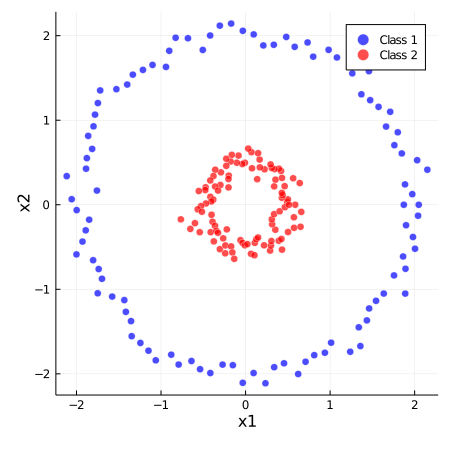

In [6]:
function plot_points(points_1::AbstractMatrix, points_2::AbstractMatrix; kwargs...)
    scatter(
        points_1[1, :], points_1[2, :];
        color=:blue,
        label="Class 1",
        aspectratio=:equal,
        size=(450, 450)
    )
    scatter!(
        points_2[1, :], points_2[2, :];
        color=:red, 
        label="Class 2",
        kwargs...
    )
end

function plot_points!(points_1::AbstractMatrix, points_2::AbstractMatrix; kwargs...)
    scatter!(
        points_1[1, :], points_1[2, :];
        color=:blue,
        label="Class 1",
        aspectratio=:equal,
        size=(450, 450)
    )
    scatter!(
        points_2[1, :], points_2[2, :];
        color=:red, 
        label="Class 2",
        kwargs...
    )
end

plot_points(circle_1, circle_2; xlabel="x1", ylabel="x2")

Now suppose we would like to design a neural network that partitions the 2-D space in a way that cleanly separates the blue and points.

## 1.1. Create a training dataset

The first thing we need to do is package our known data (the two sets of points) to prepare for training a neural network. We want the network to "learn" that points similar to the blue points belong to one class, while points similar to the red points belong to the other.
We can concatenate both sets of points together to obtain an input training dataset:

In [7]:
X_train = [circle_1 circle_2]

2×200 Array{Float64,2}:
 1.87181  1.97228   1.88614   2.15061   2.03003  …   0.465025    0.514014
 0.0      0.125342  0.240708  0.414495  0.52672     -0.0295532  -1.25897e-16

Next we need to tell the neural network what outputs should correspond to the inputs in X_train. We will associate each class with a numeric label: Class 1 will correspond to -1, and Class 2 will correspond to +1.

We need to construct a variable Y_train such that the neural network realizes the mathematical transformation X_train $\mapsto$ Y_train. The first step in the construction of Y_train for supervised classification tsks involves choosing the mathematical encoding of the classes as we did in the binary and multi-class classification codices. The next and **most important step** is constructing Y_train to be of shape (or dimensions) so that it is compatible with the neural network input-output model.

For the purpose of this codex, we shall choose  -1 to encode vectors belonging to circle_1 and  +1 to encode vectors labeled as belonging to the circle_2. Thus X_train{:,i] will be mapped to a scalar so the network will be modeling the transformation $\mathbb{R}^{2} \mapsto \mathbb{R}^1$.

There is a choice to be made even as it is clear that to effect the transformation $\mathbb{R}^2 \mapsto \mathbb{R}$ one of the dimensions of Y_train should equal one (corresponding to the scalar valued class encoding).

A **convention** to follow is that if the columns (or rows) of X_train represent the different input vectors then the columns (or rows) of Y_train should as well.

The code below constructs Y_train consistent with this convention. Note the use of the permutedims command in lie of the to construc

In [8]:
y1, y2 = -1, 1
Y_train_column = [fill(y1, num_points); fill(y2, num_points)]
@show size(Y_train_column)
Y_train = permutedims(Y_train_column)
@show size(Y_train);

size(Y_train_column) = (200,)
size(Y_train) = (1, 200)


Note the use of permutedims to construct Y_train of the desired shape. We could alternately have used the command

In [9]:
Y_train = [fill(y1, (1,num_points)) fill(y2, (1,num_points))]

1×200 Array{Int64,2}:
 -1  -1  -1  -1  -1  -1  -1  -1  -1  …  1  1  1  1  1  1  1  1  1  1  1  1

which brings into sharper focus how the desired shape of Y_train is obtained by the horizontal concatenation of two arrays  of the desired shape.As we saw in the binary classification codex, we must also choose a decision threshold. This value represents the point halfway between the two numerical class labels. Outputs below $\tau$ will be labeled with Class 1, while outputs above it will be labeled Class 2.

In [10]:
τ = 0

0

At this point, each element of Y_train represents the desired neural network output for the corresponding point (column) in X_train. It is important to note that the input to the neural network has to match the number of rows of X_train (dimensionality of each point), while the output must be one-dimensional.

## 1.2. Training a single-output linear neural network with a hidden layer

Consider the progress we have already made. The original problem description was "learn to separate Class 1 and Class 2". It is not obvious how a computer can accomplish this vague-sounding goal. But now we have a new and equivalent description: "learn to associate points closer to Class 1 with the number -1, and associate points closer to Class 2 with the number +1."

In the nested circle example from above, each input sample is 2-dimensional, and each output is 1-dimensional (the class label is either $+1$ or $-1$). Thus, we are looking for a neural network that maps 2-dimensional Class 1 samples as closely as possible to -1, and 2-dimensional Class 2 samples as closely as possible to +1.

There is still some vagueness in our description. What does "as close as possible" mean mathematically? We answer this question by defining a loss function. The loss function is used to compute the distance between any two neural network outputs. In other words, we say two points are "closer" if the loss function output for those two points is smaller.

There are many valid loss functions. We will first use the mean-squared error (MSE, or mse in Flux) loss function. Later we will use cross entropy (cross_entropy in Flux) and explain how the two functions differ. The study of trade-offs between loss functions is an area of active research.

Now that we have translated from vague-sounding words to concrete mathematics, it's time to set up and train a deep feedforward network with a linear activation function. This may sound nasty, but a deep neural network is just a neural network with hidden layers. Here is a depiction of a 2-layer deep feedforward network:

![2-Layer Deep Feed Forward Network](https://storage.googleapis.com/mynerva-testing-static/neural201-2a932d3b615f6485a53347a4016f347673376ceb-dense_network.jpeg)

If you have set up neural networks from scratch already, you may have an idea of how to create a neural network like the one shown above. You also probably realize that the code will get messy and repetitive very quickly. To express arbitrarily complicated neural networks while keeping the code tidy and readable, we will use Julia's Flux package. This package will help us construct and train deep neural nets.

The `Dense` command in `Flux` constructs a dense network. Thus, for example, the

In [11]:
m = Dense(10, 2, relu)

Dense(10, 2, relu)

produces a dense (i.e. fully-connected) layer with 10 input neurons and 2 outputs, and a `relu` activation function that is applied to the output of neuron. If we omit the argument specifying the activation function, Flux assumes we want to use the linear activation function. Thus, the following line produces a dense (or fully-connected) layer with 10 input neurons and 2 output neurons, each having the default linear activation function:

In [12]:
m = Dense(10, 2)

Dense(10, 2)

Many activation functions are available in `Flux` (see the documentation), including:

- `σ` which is equivalent to the sigmoid function
- `relu`
- `leakyrelu`
- `elu`

There are many other activation functions, with a great deal of active research and anecdotal evidence surrounding them.

Initialize a single output, dense linear neural network that we will use to classify the concentric circle dataset from earlier by filling in the `??` in the cell below.
Hint: the first argument should match the dimensionality of the input vectors encoded by the columns of `X_train`. This the columns as input vectors convention in `Flux.jl`.

In [13]:
m = Dense(2, 1)

Dense(2, 1)

The model is initialized with random weights. Let us pass `X_train` to the model `m` by entering `m(X_train)`. If you have set up the model correctly, the output should have 200 columns.

Note: If the model you constructed above does not have the right number of dimensions for the first input argument, then `m(X_train)` will result in a `DimensionMismatch` error because of the mismatch with the number of dimensions of the input vector (columns of `X_train`).

In [14]:
println("Output has size $(size(m(X_train), 2))")

Output has size 200


Our untrained model `m` is not useful until we train it. Run the following code to visualize its output when given our training data `X_train`:

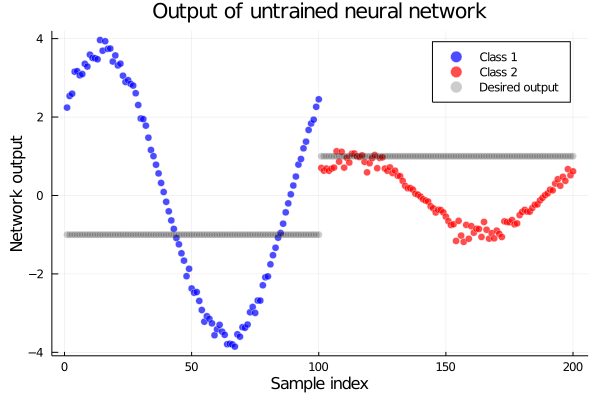

In [15]:
Y_untrained = m(X_train) |> vec # the vec converts to a column vector so we can plot it
scatter(
    1:num_points, Y_untrained[1:num_points];
    color=:blue,
    label="Class 1",
    xlabel="Sample index",
    ylabel="Network output",
    title="Output of untrained neural network"
)
scatter!(
    (num_points + 1):(2 * num_points), Y_untrained[(num_points + 1):end];
    color=:red,
    label="Class 2"
)

scatter!(vec(Y_train); color=:black, alpha=0.2, label="Desired output")

As you can see, the network output for an input point seems to depend on where that point is on the circle. This is not useful: we only care which circle a point is closer to, not where it is on that circle. Thus, we would like the network output to look like the "Desired output" series shown in gray. As we expressed earlier, the output should be -1 for points in Class 1, and +1 for points in Class 2.

Clearly we have some training to do!

To train the network, we will need a loss function. Let's use the most common one: mean-squared-error. Note how the loss is computed by comparing `m(x)`, the output of the model, to some desired output `y`:

In [5]:
loss(x, y) = mse(m(x), y) 

We now package the dataset into `(X_train, Y_train)` tuples, repeating the tuple for the desired number of iterations. The syntax `((X_train, Y_train) for _ in 1:iters)` produces a `Generator`, which represents repeating the tuple `(X_train, Y_train)` iters times. A `Generator` is memory-efficient because it is "lazy". It does not actually store all the repeated `(X_train, Y_train)` tuples -- that would be a big waste of space! Instead, it stores the rule for generating these tuples one at a time.

Note also the use of `_` (the underscore) as an iteration variable. It is a common programming convention to use `_` as an iteration variable when the iteration value is not used during iteration; in other words, when the only thing that matters is the number of iterations in total.

In [16]:
iters = 1000
dataset = ((X_train, Y_train) for _ in 1:iters)

Base.Generator{UnitRange{Int64},var&quot;#3#4&quot;}(var&quot;#3#4&quot;(), 1:1000)